In [1]:
import os
import numpy as np
import pandas as pd
from bambi import Model

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("axes.spines", top=False, right=False)

from plotting_functions import show_img, cm2inch, plot_correlation
from pymc3 import plot_posterior

## Load subject summary of behavioral measures

In [2]:
subject_summary = pd.read_csv('results/descriptives/subject_summary.csv', index_col=[0], header=[0, 1])
subject_summary.head()

subject           rt                                            \
  Unnamed: 1_level_1         mean          std     min      max          se   
0                  0  1762.538462  1221.112889   682.0   7866.0  128.716600   
1                  1  1672.050505   868.963929   667.0   4826.0   87.778612   
2                  2  4477.180000  3088.070399   943.0  15825.0  310.362753   
3                  3  1882.613636   541.973214  1003.0   4742.0   58.105628   
4                  4  1727.370000  1007.248844   673.0   5891.0  101.232318   

                             best_chosen      gaze_influence  \
        q1       q3      iqr        mean Unnamed: 11_level_1   
0  1107.00  1970.50   863.50    0.857143            0.040579   
1  1108.50  1862.00   753.50    0.737374            0.202390   
2  2146.25  5728.50  3582.25    0.850000            0.032181   
3  1519.50  2180.25   660.75    0.693182            0.071577   
4  1160.50  1868.00   707.50    0.840000            0.141787   

              dataset  
  Unnamed: 12_level_1  
0        krajbich2010  
1        krajbich2010  
2        krajbich2010  
3        krajbich2010  
4        krajbich2010

# 2.2 Relative model fit (individual level model comparison)

## Load WAICs

In [3]:
waic_summaries = [file for file in os.listdir('results/model_comparison/multiplicative_vs_nobias/')
                  if file.endswith('waic.csv')]

n_krajbich2010 = 39
n_krajbich2011 = 30
n_folke2016 = 24
n_tavares2017 = 25
n = n_krajbich2010 + n_krajbich2011 + n_folke2016 + n_tavares2017

waic = pd.DataFrame(dict(subject=np.arange(n)))
waic['dWAIC'] = np.nan
waic['dSE'] = np.nan
waic['dataset'] = np.nan
waic['warning'] = np.nan

for file in waic_summaries:
    _, _, _, subject, _ = file.split('_')
    subject = int(subject)
    dataset = subject_summary.loc[subject, 'dataset'].values[0]

    waic_summary = pd.read_csv(os.path.join('results', 'model_comparison', 'multiplicative_vs_nobias', file), index_col='Unnamed: 0')
    waic.loc[waic['subject'] == subject, 'dWAIC'] = waic_summary.loc['GLAM', 'WAIC'] - waic_summary.loc['nobias', 'WAIC']
    waic.loc[waic['subject'] == subject, 'dSE'] = waic_summary['dSE'].values[1]
    waic.loc[waic['subject'] == subject, 'dataset'] = dataset
    waic.loc[waic['subject'] == subject, 'warning'] = waic_summary['var_warn'].sum()
    
waic.head()

,subject,dWAIC,dSE,dataset,warning
0,0,-0.74,2.48,krajbich2010,0.0
1,1,-21.53,9.18,krajbich2010,0.0
2,2,0.98,1.48,krajbich2010,0.0
3,3,0.81,3.01,krajbich2010,0.0
4,4,-9.55,5.75,krajbich2010,0.0


In [4]:
waic['dWAIC'].describe()

count    118.000000
mean     -62.081949
std       80.795577
min     -400.640000
25%      -82.307500
50%      -33.605000
75%       -7.430000
max        1.600000
Name: dWAIC, dtype: float64

In [5]:
np.sum(waic['dWAIC'] < 0)

109

In [6]:
np.mean(waic['dWAIC'] < 0)

0.923728813559322

In [7]:
waic.groupby('dataset').apply(lambda x: np.mean(x['dWAIC'] < 0))

dataset
folke2016       1.000000
krajbich2010    0.794872
krajbich2011    0.966667
tavares2017     1.000000
dtype: float64

# Run mixed effects regressions, accounting for dataset level

In [8]:
subject_summary.head()

subject           rt                                            \
  Unnamed: 1_level_1         mean          std     min      max          se   
0                  0  1762.538462  1221.112889   682.0   7866.0  128.716600   
1                  1  1672.050505   868.963929   667.0   4826.0   87.778612   
2                  2  4477.180000  3088.070399   943.0  15825.0  310.362753   
3                  3  1882.613636   541.973214  1003.0   4742.0   58.105628   
4                  4  1727.370000  1007.248844   673.0   5891.0  101.232318   

                             best_chosen      gaze_influence  \
        q1       q3      iqr        mean Unnamed: 11_level_1   
0  1107.00  1970.50   863.50    0.857143            0.040579   
1  1108.50  1862.00   753.50    0.737374            0.202390   
2  2146.25  5728.50  3582.25    0.850000            0.032181   
3  1519.50  2180.25   660.75    0.693182            0.071577   
4  1160.50  1868.00   707.50    0.840000            0.141787   

              dataset  
  Unnamed: 12_level_1  
0        krajbich2010  
1        krajbich2010  
2        krajbich2010  
3        krajbich2010  
4        krajbich2010

In [9]:
def prepare_df_for_bambi(waic, subject_summary):
    df = pd.DataFrame(dict(subject=waic['subject'],
                           dWAIC=waic['dWAIC'],
                           dataset=waic['dataset'],
                           mean_rt=subject_summary['rt']['mean'],
                           best_chosen=100 * subject_summary['best_chosen']['mean'],
                           gaze_influence=100 * subject_summary['gaze_influence']['Unnamed: 11_level_1']))
    return df

In [10]:
mfx_df = prepare_df_for_bambi(waic, subject_summary)

In [11]:
mfx_df.head()

,best_chosen,dWAIC,dataset,gaze_influence,mean_rt,subject
0,85.714286,-0.74,krajbich2010,4.057934,1762.538462,0
1,73.737374,-21.53,krajbich2010,20.238963,1672.050505,1
2,85.000000,0.98,krajbich2010,3.218073,4477.180000,2
3,69.318182,0.81,krajbich2010,7.157652,1882.613636,3
4,84.000000,-9.55,krajbich2010,14.178662,1727.370000,4


In [12]:
n_samples = 20000

In [13]:
result_path = os.path.join('results', 'mixed_effects_models', '2_relative_model_comparison_b_mean_rt.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    b_mean_rt_fit = m.fit('mean_rt ~ dWAIC',
                          random=['dWAIC|dataset'],
                          categorical=['dataset'],
                          samples=n_samples)
    b_summary = b_mean_rt_fit.summary(ranefs=True)
    b_summary.to_csv(result_path)
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    b_summary = pd.read_csv(result_path, index_col=0)
b_summary

Previous results loaded from "results/mixed_effects_models/2_relative_model_comparison_b_mean_rt.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,3018.413606,740.492000,1697.350531,4664.071945,236,1.012394
dWAIC|dataset[folke2016],-2.264231,5.428171,-15.265071,7.562233,138,1.007388
dWAIC|dataset[krajbich2010],3.929004,7.591286,-7.126642,21.757592,84,1.012804
dWAIC|dataset[krajbich2011],0.766852,5.568722,-9.497250,15.329559,65,1.024069
dWAIC|dataset[tavares2017],-0.316185,5.330837,-11.273393,15.452821,47,1.029550
dWAIC|dataset_sd,6.098573,5.438404,0.001251,17.039704,123,1.003957
1|dataset[folke2016],2253.237608,779.963533,693.567832,3799.449096,337,1.002170
1|dataset[krajbich2010],-758.520704,747.559973,-2340.662162,671.110617,268,1.011362
1|dataset[krajbich2011],-480.632014,750.650099,-2112.649017,975.235279,293,1.008871
1|dataset[tavares2017],-1004.691123,762.858145,-2508.961853,507.980766,430,1.006865


In [14]:
result_path = os.path.join('results', 'mixed_effects_models', '2_relative_model_comparison_c_best_chosen.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    c_best_chosen_fit = m.fit('best_chosen ~ dWAIC',
                              random=['dWAIC|dataset'],
                              categorical=['dataset'],
                              samples=n_samples)
    c_summary = c_best_chosen_fit.summary(ranefs=True)
    c_summary.to_csv(result_path)
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    c_summary = pd.read_csv(result_path, index_col=0)
c_summary

Previous results loaded from "results/mixed_effects_models/2_relative_model_comparison_c_best_chosen.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],-3.037726,3.692019,-10.930851,3.819971,15732,0.999990
1|dataset[krajbich2010],1.492997,3.258928,-5.091004,8.290051,11386,1.000025
1|dataset[krajbich2011],-2.438621,3.349371,-9.703574,4.007553,12798,1.000005
1|dataset[tavares2017],4.928456,3.863594,-1.695214,13.199760,12516,0.999999
1|dataset_sd,5.416193,2.985705,0.239002,11.240824,11559,0.999977
Intercept,81.193962,3.156818,74.836674,87.899151,10785,1.000003
best_chosen_sd,7.379101,0.509492,6.441272,8.433300,33344,0.999987
dWAIC,0.103594,0.056698,-0.013960,0.216177,5169,1.000144
dWAIC|dataset[folke2016],0.083300,0.063005,-0.037683,0.213422,7895,1.000177
dWAIC|dataset[krajbich2010],0.023669,0.074038,-0.122391,0.174967,12197,1.000027


Results loaded from: results/mixed_effects_models/2_relative_model_comparison_c_best_chosen_posteriorplot.png


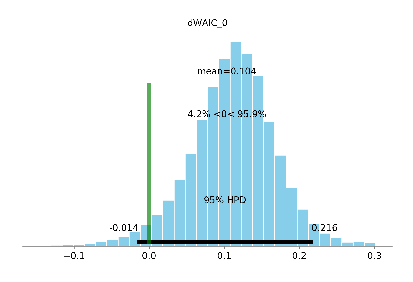

In [15]:
plot_path = os.path.join('results', 'mixed_effects_models', '2_relative_model_comparison_c_best_chosen_posteriorplot.png')
if not os.path.isfile(plot_path):
    plot_posterior(m.backend.trace, varnames=['dWAIC'], ref_val=0)
    plt.savefig(plot_path, dpi = 330)
else:
    print('Results loaded from: {}'.format(plot_path))
    show_img(plot_path)

In [16]:
result_path = os.path.join('results', 'mixed_effects_models', '2_relative_model_comparison_d_gaze_influence.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    d_gaze_influence_fit = m.fit('gaze_influence ~ dWAIC', 
                                 random=['dWAIC|dataset'],
                                 categorical=['dataset'],
                                 samples=n_samples)
    d_summary = d_gaze_influence_fit.summary(ranefs=True)
    d_summary.to_csv(result_path)
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    d_summary = pd.read_csv(result_path, index_col=0)
d_summary

Previous results loaded from "results/mixed_effects_models/2_relative_model_comparison_d_gaze_influence.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],2.514997,3.523715,-3.850334,10.189233,15389,0.999987
1|dataset[krajbich2010],-1.871083,3.129804,-8.439211,4.084390,11903,1.000017
1|dataset[krajbich2011],1.149952,3.104042,-5.255793,7.622787,14329,1.000006
1|dataset[tavares2017],-3.049778,3.596354,-10.863824,2.893496,12576,1.000105
1|dataset_sd,4.569710,3.274987,0.001060,10.837882,8581,0.999981
Intercept,11.267927,2.976148,5.648708,17.665784,12336,1.000009
dWAIC,-0.208423,0.109235,-0.415993,0.010731,5731,0.999987
dWAIC|dataset[folke2016],-0.085523,0.113878,-0.314477,0.132726,6219,0.999989
dWAIC|dataset[krajbich2010],-0.622183,0.133612,-0.884679,-0.361419,7433,0.999984
dWAIC|dataset[krajbich2011],-0.124041,0.113100,-0.351546,0.088626,6239,0.999977


Results loaded from: results/mixed_effects_models/2_relative_model_comparison_d_gaze_influence_posteriorplot.png


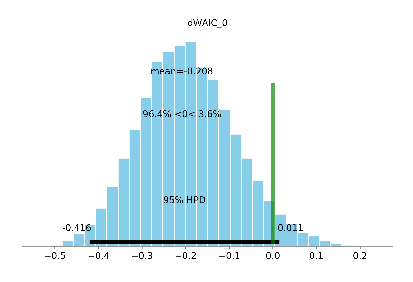

In [17]:
plot_path = os.path.join('results', 'mixed_effects_models', '2_relative_model_comparison_d_gaze_influence_posteriorplot.png')
if not os.path.isfile(plot_path):
    plot_posterior(m.backend.trace, varnames=['dWAIC'], ref_val=0)
    plt.savefig(plot_path, dpi=330)
else:
    print('Results loaded from: {}'.format(plot_path))
    show_img(plot_path)

# Plot DIC differences between full and no-gaze bias GLAM variant

In [18]:
def figure_4(waic, colors=None, fontsize=7, figsize=cm2inch(18,6), plot_type='bar', log_scale=False, ylim=(-100, 5)):

    # Log transform: add minimum dWAIC + 1, then log-transform, new indifference then at log(minimum dWAIC + 1)
    waic = waic.copy()
    if log_scale:
        min_dWAIC = np.min(waic['dWAIC'])
        indifference_level = np.log(np.abs(min_dWAIC) + 1)
        waic['plotted_dWAIC'] = np.log(waic['dWAIC'] + np.abs(min_dWAIC) + 1)
    else:
        indifference_level = 0
        waic['plotted_dWAIC'] = waic['dWAIC']
    
    if colors is None:
        colors = np.array(['C{}'.format(i) for i in range(10)])

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']
    dataset_labels = ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017']
    
    fig = plt.figure(figsize=figsize)

    ax0 = plt.subplot2grid((1, 3), (0, 0))
    ax1 = plt.subplot2grid((1, 3), (0, 1), colspan=2)

    sorting_idx = np.argsort(waic['plotted_dWAIC'])
    color_idx = pd.Categorical(waic['dataset'], categories=datasets).codes
    patches = []
    
    for i, dataset in enumerate(datasets):
        
        if plot_type == 'bar':
            ax1.bar(np.arange(len(waic))[waic['dataset'][sorting_idx] == dataset],
                        waic['plotted_dWAIC'][sorting_idx][waic['dataset'][sorting_idx] == dataset],
                        color=colors[i])
        
        else:
            ax1.scatter(np.arange(len(waic))[waic['dataset'][sorting_idx] == dataset],
                        waic['plotted_dWAIC'][sorting_idx][waic['dataset'][sorting_idx] == dataset],
                        color=colors[i], marker='+')
        
        bars = ax0.bar(i, 100 * np.mean(waic.loc[waic['dataset'] == dataset, 'dWAIC'] < 0), color=colors[i])
        patches.append(bars[0])        

    # Legend
    ax1.legend(patches,
               ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
               ncol=2,
               loc='lower right',
               handlelength=1, handleheight=1,
               fontsize=7, columnspacing=1,
               frameon=False)
    
    # Labels    
    ax0.tick_params(axis='both', which='major', labelsize=fontsize)
    ax0.set_xticks(np.arange(len(datasets)))
    ax0.set_xticklabels(dataset_labels, fontsize=fontsize, rotation=45)
    ax0.set_yticks(np.arange(0, 110, 20))
    ax0.set_ylim(0, 100)
    ax0.set_ylabel('% Participants\nwith gaze bias', fontsize=fontsize)
    
    ax1.set_xlabel('Participant', fontsize=fontsize)
    if log_scale:
        ax1.set_ylabel('Log(dWAIC))', fontsize=fontsize)
    else:
        ax1.set_ylabel('WAIC(with bias)-\nWAIC(without bias)',fontsize=fontsize)
    ax1.set_xticks([])
    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    
    
    ax1.axhline(indifference_level, color='black', lw=1, zorder=9)
    
    ax1.set_ylim(ylim)
    
    # Labels
    ax0.text(-0.4, 1.05, 'a', transform=ax0.transAxes,
            fontsize=fontsize, fontweight='bold', va='top')
    
    ax1.text(-0.175, 1.05, 'b', transform=ax1.transAxes,
            fontsize=fontsize, fontweight='bold', va='top')
    
    
        
    fig.tight_layout()
    
    return fig

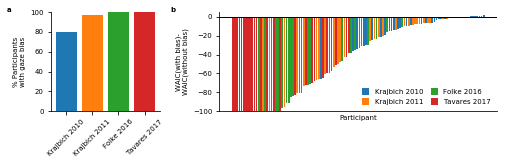

In [19]:
fig = figure_4(waic);
fig.savefig('results/figures/figure_4_relative_model_comparison.png', dpi=330, bbox_inches='tight')
fig.savefig('results/figures/figure_4_relative_model_comparison.pdf', dpi=330, bbox_inches='tight')
plt.show()